In [30]:
## Support Functions
import hashlib
def sha1(obj: str):
    return hashlib.sha1(str(obj).encode('utf-8')).hexdigest()

In [31]:
## Block
class Block:
    duration = 0
    
    def __init__(self, height, pre_hash, merkle, nouce, transactions):
        self.height = height
        self.pre_hash = pre_hash
        self.merkle = merkle
        self.nouce = nouce
        self.transactions = transactions

    def getHash(self):
        return sha1(self)
    
    def __repr__(self):
        return str(self.pre_hash) + str(self.height) + str(self.merkle) + str(self.nouce)
    
    def printJSON(self):
        # DFS or BFS
        print("Hash:", self.getHash(), "Height:", self.height, "Pre_Hash:", self.pre_hash, "Merkle Hash:", self.merkle, "nouce:", self.nouce)
        pass

In [32]:
## mine difficaulty
## 40 - 4 = 36
## hash value should smaller than DIFFICULTY
import math
DIFFICULTY = 0x00000FFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFF

print('Mine DIFFICULTY:', math.log2(DIFFICULTY))


Mine DIFFICULTY: 140.0


In [33]:
import matplotlib.pyplot as plt
def visualization(blocks):
    x = range(len(blocks))
    y = [block.duration if block.duration < 400 else 400 for block in blocks]
    x_standard = range(len(blocks))
    y_standard = [0.3 for i in x_standard]
    plt.figure(figsize=(30,20)) 
    l1=plt.plot(x,y,'r--',label='Mining')
    l2=plt.plot(x_standard,y_standard,'g--',label='Standard')
    plt.plot(x,y,'ro-',x_standard,y_standard,'g+-')
    plt.xlabel("Height")
    plt.ylabel("Time(s)")
    plt.legend()
    plt.title("Time Analysis")

def visualization2(logs):
    x = range(len(logs)-1)
    y = logs[1:]
    plt.figure(figsize=(20,10)) 
    plt.plot(x,y)
    plt.xlabel("Height")
    plt.ylabel("Diff")

In [34]:
import math
kp = 0.1
ki = 0.001 #0.001
kd = 0.002 #0.002
difficulties = [DIFFICULTY]
def adjustmentDifficulty(old_Difficulty,height):
    old_Difficulty = math.log2(old_Difficulty)
    ut = kp*errors[height] + ki * errors_sum + kd*(errors[height] - errors[height-1])
    new_Difficulty = old_Difficulty - ut
    difficulties.append(new_Difficulty)
#     print('********************************************************')
#     print('Difficulty cahnge: ', ut, ' Difficulties: ', difficulties)
#     print('********************************************************')
    return math.pow(2,  new_Difficulty)  

def adjustmentDifficulty2(old_Difficulty):
    old_Difficulty = math.log2(old_Difficulty)
    previous_ten_durations = durations[len(durations)-10:len(durations)]
    sum = 0
    for duration in previous_ten_durations:
        sum += duration
        
    new_Difficulty = old_Difficulty * sum / (10 * 0.3) # change difficulty every 10 blocks 
    difficulties.append(new_Difficulty)
#     print('********************************************************')
#     print('Difficulties: ', difficulties)
#     print('********************************************************')
    return math.pow(2,  new_Difficulty)

In [35]:
import random
import sys
import math
import os
from datetime import datetime
from multiprocessing import Process, Pool, Queue, Manager

blocks = []
errors = [0]
durations = []
errors_sum = 0
pre_hash = '0'
height = 1
max_nounce = math.pow(2,20)   # reduce calculate time

def long_time_task(i, queue, start, stop, height, pre_hash, merkle, diff):
    start_time = datetime.now()
    for z in range(start, stop):
        block = Block(height, pre_hash, merkle, z, [])
        temp = block.getHash()
        if int(temp, 16) < diff:
            queue.put(z)

# nodes = [100, 130, 80, 120, 70, 130, 80, 120]
nodes = [100, 100, 100, 100, 20, 20, 20, 20, 100, 100, 100, 100]

while height < 1200:
    merkle = sha1(random.random())
    nodes_number = 16
    unit_nounce = max_nounce // nodes_number
    p = Pool()
    queue = Manager().Queue()

    for i in range(nodes_number):
        start = int(i * unit_nounce) # nounce
        stop = int((i + 1) * unit_nounce)
        p.apply_async(long_time_task, args = (i, queue, start, stop, height, pre_hash, merkle, DIFFICULTY))
    
    p.close()
    p.join()
    
    number_of_nounce = queue.qsize()
    
    if number_of_nounce == 0:
        continue
        
    block = Block(height, pre_hash, merkle, number_of_nounce, [])
    index = height//100
    duration = 240 / (number_of_nounce * nodes[index])
    block.duration = duration
    
    blocks.append(block)
    durations.append(duration)
    
    error = 0.3 - duration
    errors.append(error)
    errors_sum += error
    
#     new strategy
    DIFFICULTY = adjustmentDifficulty(DIFFICULTY,height)

    #old strategy
#     if height%10 == 0:
#         DIFFICULTY = adjustmentDifficulty2(DIFFICULTY)
    
    height += 1
    pre_hash = block.getHash()
    

In [ ]:
# 参数整定找最佳， 从小到大顺序查。
# 先是比例后积分， 最后再把微分加。
# 曲线振荡很频繁， 比例度盘要放大。
# 曲线漂浮绕大弯， 比例度盘往小扳。
# 曲线偏离回复慢， 积分时间往下降。
# 曲线波动周期长， 积分时间再加长。
# 曲线振荡频率快， 先把微分降下来。
# 动差大来波动慢， 微分时间应加长。
# 理想曲线两个波， 前高后低四比一。
# 一看二调多分析， 调节质量不会低。

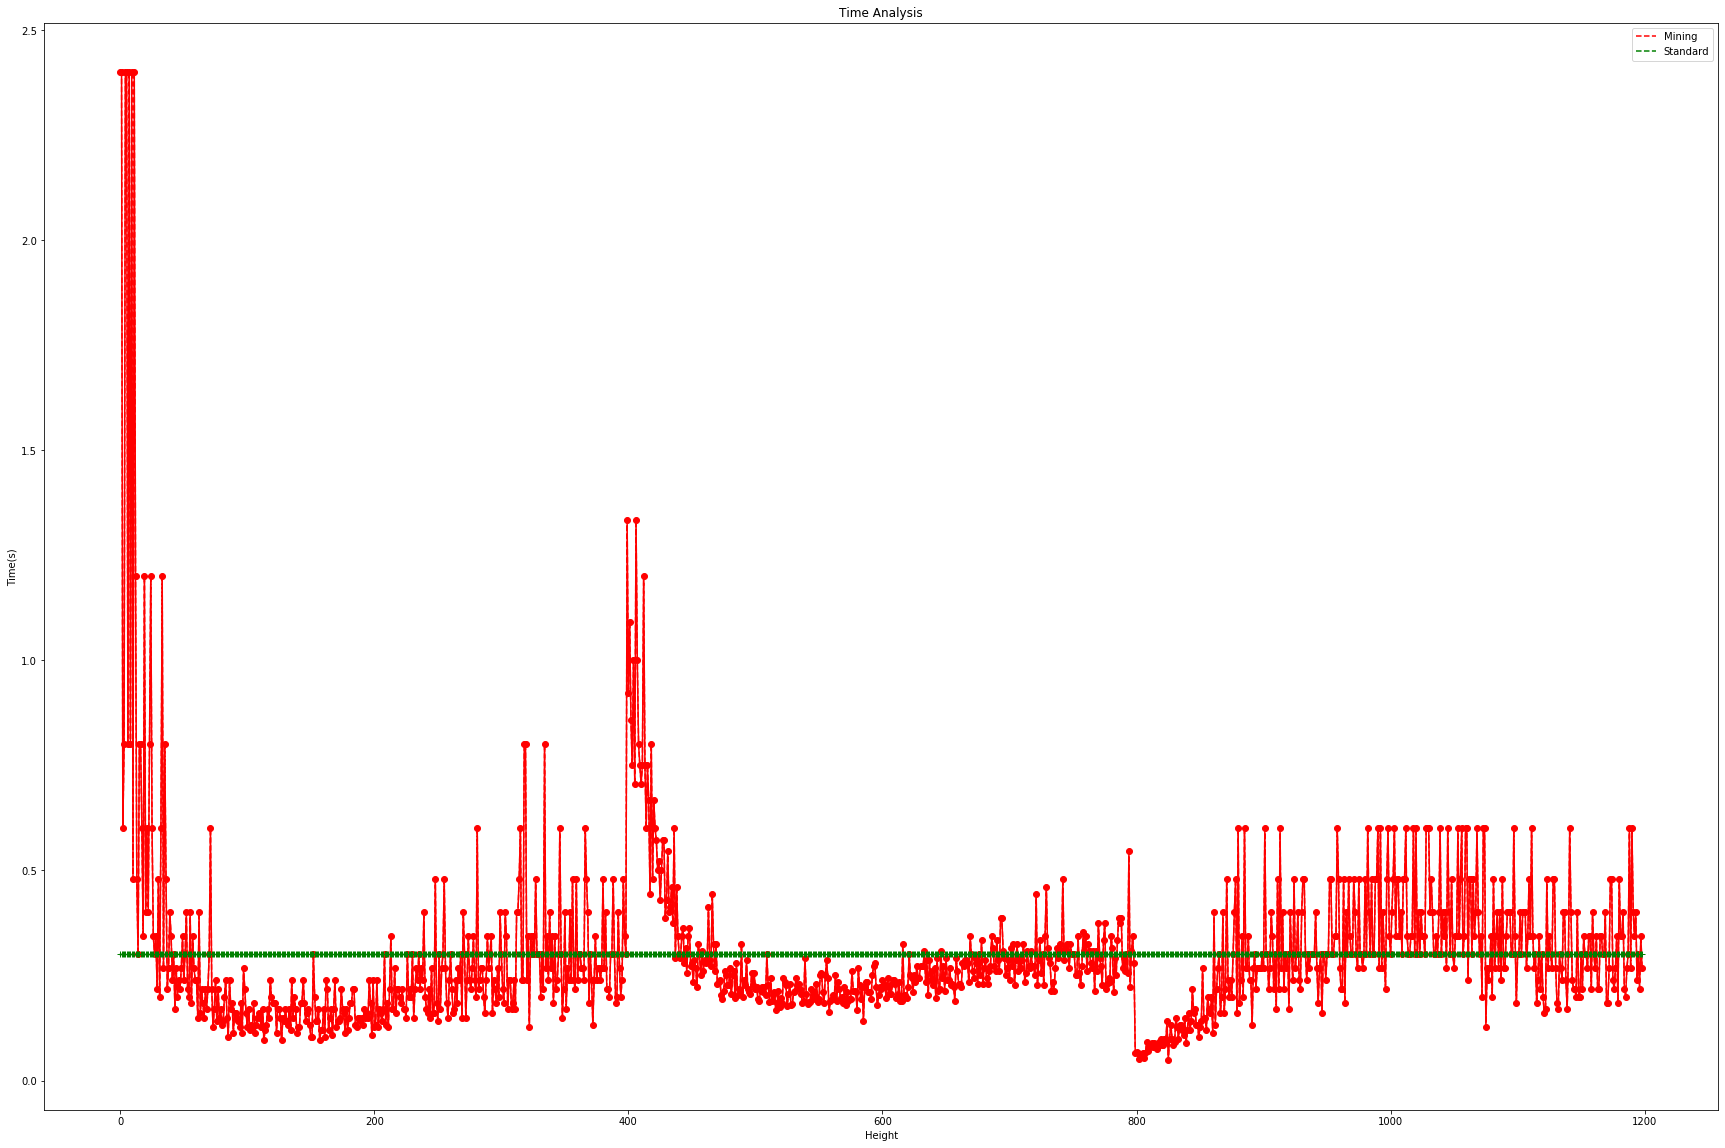

In [36]:
visualization(blocks)

In [37]:
import numpy as np
import math

# processing_durations = []
# for i in range(len(durations)):
    

arr_mean = np.mean(durations)
arr_var = np.var(durations)
arr_std = np.std(durations,ddof=1)
print("平均值为：%f" % arr_mean)
print("方差为：%f" % arr_var)
print("标准差为:%f" % arr_std)

converge_height = 0
for i in range(len(durations)):
    temp_mean = np.mean(durations[0:i+1])
    if abs(temp_mean - 0.3) < 0.0001:
        print('Fined converge height', i)
        converge_height = i
        break

平均值为：0.301090
方差为：0.049892
标准差为:0.223458
Fined converge height 262


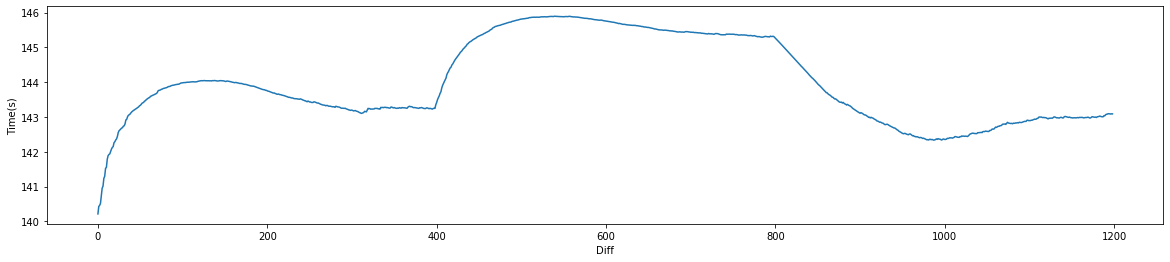

In [38]:
import matplotlib.pyplot as plt
def visualization2(logs):
    x = range(len(logs)-1)
    y = logs[1:]
    plt.figure(figsize=(20,4)) 
    plt.plot(x,y)
    plt.xlabel("Diff")
    plt.ylabel("Time(s)")

visualization2(difficulties)